In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import datasets, metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("../Data/Hourly consumtpion per cluster London.csv")
df["time"] = df["time"].astype(str).str.zfill(3)
df.index = df["time"]
df["day"] = df["time"].str[:1]
df["hour"] = df["time"].str[1:]
df.drop(['time','Unnamed: 0'], axis = 1, inplace = True)


df.head()

,Cluster,consumption_kWh,CO2_intensity,day,hour
time,,,,,
000,0,33.813385,206.339623,0,00
001,0,37.310308,214.980769,0,01
002,0,29.514769,214.673077,0,02
003,0,31.131462,215.509615,0,03
004,0,39.650769,216.461538,0,04


NameError: name 'a' is not defined

,consumption_kWh,hour,CO2_intensity
time,,,
000,587.238769,0,206.339623
001,487.561051,0,214.980769
002,413.403647,0,214.673077
003,378.318955,0,215.509615
004,367.642231,0,216.461538


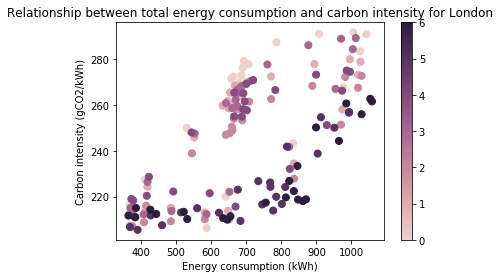

In [5]:
a = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()

a['hour'] = a.index.str[:1].astype(int)


z = df.iloc[range(0,168),-3]
a["CO2_intensity"] = z


cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(a['consumption_kWh'], y = a['CO2_intensity'], c=a['hour'], s=50, cmap=cmap)
f.colorbar(points)


plt.title("Relationship between total energy consumption and carbon intensity for London")
plt.xlabel("Energy consumption (kWh)")
plt.ylabel("Carbon intensity (gCO2/kWh)")

plt.savefig("Carbon Intensity vs Consumption London.png")

a.head()

In [6]:
a['consumption_kWh'].corr(a['CO2_intensity'])

0.6462240151104416

In [7]:
week = df.groupby('time')['consumption_kWh'].apply(lambda x: np.sum(x)).to_frame()
week["day"] = week.index.str[:1]
week["hour"] = week.index.str[1:]

z = df.iloc[range(0,168),-3]
week["CO2_intensity"] = z


len(week)

168

### Multivariate regression

In [8]:
train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
lr = LinearRegression()



In [41]:
X_train = np.array(train_data[['consumption_kWh','day','hour']],
                   dtype = pd.Series)
y_train = np.array(train_data['CO2_intensity'], dtype = pd.Series)
lr.fit(X_train, y_train)

X_test = np.array(test_data[['consumption_kWh','day','hour']], 
                    dtype = pd.Series)
y_test = np.array(test_data['CO2_intensity'], dtype = pd.Series)

pred = lr.predict(X_test)

rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))

print(rmsesm)

16.728


### Decision tree 

In [10]:
train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
clf = tree.DecisionTreeRegressor()

In [54]:
sm = 0
r = 0
for i in range(1,4000):

    X_train = np.array(train_data[['consumption_kWh','day','hour']],
                       dtype = pd.Series)
    y_train = np.array(train_data['CO2_intensity'], dtype = pd.Series)
    clf.fit(X_train, y_train)

    X_test = np.array(test_data[['consumption_kWh','day','hour']], 
                        dtype = pd.Series)
    y_test = np.array(test_data['CO2_intensity'], dtype = pd.Series)

    pred = clf.predict(X_test)

    rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
    
    sm +=rmsesm
    r+=1
    
print(sm/r)

7.790096024006011


### Random forest 

In [61]:
train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
regr = RandomForestRegressor(max_depth= 8, random_state=0)


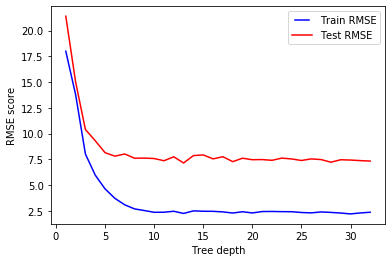

In [10]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []

X_train = np.array(train_data[['consumption_kWh','day','hour']],
                   dtype = pd.Series)
y_train = np.array(train_data['CO2_intensity'], dtype = pd.Series)

X_test = np.array(test_data[['consumption_kWh','day','hour']], 
                    dtype = pd.Series)
y_test = np.array(test_data['CO2_intensity'], dtype = pd.Series)


for max_depth in max_depths:
    rf = RandomForestRegressor(max_depth=max_depth, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_pred = rf.predict(X_train)
    train_rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_train,train_pred)),'.3f'))

    train_results.append(train_rmsesm)

    y_pred = rf.predict(X_test)

    test_rmsesm = float(format(np.sqrt(metrics.mean_squared_error(y_test,y_pred)),'.3f'))
    test_results.append(test_rmsesm)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train RMSE')
line2, = plt.plot(max_depths, test_results, 'r', label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('Tree depth')
plt.show()


In [62]:
train_results = []
test_results = []

X_train = np.array(train_data[['consumption_kWh','day','hour']],
                   dtype = pd.Series)
y_train = np.array(train_data['CO2_intensity'], dtype = pd.Series)

X_test = np.array(test_data[['consumption_kWh','day','hour']], 
                    dtype = pd.Series)
y_test = np.array(test_data['CO2_intensity'], dtype = pd.Series)

regr.fit(X_train, y_train)

pred = regr.predict(X_test)
rmsesr = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))

print(rmsesr)

7.755


In [12]:
df = pd.DataFrame(list(zip(max_depths, test_results)), 
               columns =['Depth', 'RMSE']) 

So we keep depth equals 10

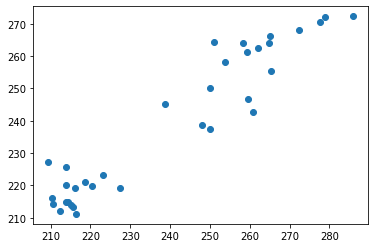

In [14]:
train_data, test_data = train_test_split(week, train_size = 0.8, random_state = 3)
rf = RandomForestRegressor(max_depth=10, random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


plt.scatter(y_test,y_pred)